# Hardware-Efficient Simulation of Energy Transfer Dynamics

Yuan Liu, 10/21/2022

In [29]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt
import pandas as pd

In [30]:
# make qutip available in the rest of the notebook
from qutip import *


## Hamiltonian
See the overleaf document for the exact Hamiltonian.

### Problem parameters


Here we use units where $\hbar = 1$, and I will use $cm^{-1}$ as frequency unit.

In [31]:
## wavenumber2GHz = 29.9792458  # 1 cm^-1 = 29.9792458 GHz, conversion factor between wave number to Hertz
wga = 4.95e13  # frequency of mode a when molecule A is at ground state (g)
wea = 4.63e13  # frequency of mode a when molecule A is at ground state (e)
wgb = 4.98e13  # frequency of mode b when molecule B is at ground state (g)
web = 4.62e13  # frequency of mode b when molecule B is at ground state (e)
wgc = 4.92e13  # frequency of mode c when molecule C is at ground state (g)
wec = 4.65e13  # frequency of mode c when molecule C is at ground state (e)
wl = 6e12    # frequency of the low frequency mode at molecule A
JAB0  = 3e12    # coupling strength between molecule A and B
JAC0  = 2.7e12    # coupling strength between molecule A and C
etaAB = -0.1       # cavity dissipation rate
etaAC = 0.15        # atom dissipation rate
Sa = 0.005          # dimensionless
Sb = 0.004          # dimensionless
Sc = 0.006          # dimensionless
Sl = 0.05           # 0~0.1, tunable

#planck = 6.62607015e-34
planck = 1

gammaA = 3.15          # qubit A amplitude damping
gammaB = 3.15          # qubit B amplitude damping
gammaC = 3.15          # qubit C amplitude damping
kappa = 0.005       # cavity dissipation rate
n_th_a = 0.0        # avg number of thermal bath excitation

N = 3             # truncation level for the high frequency modes
#Nl = N           # truncation level for the low frequency mode
Nl = N*2           # truncation level for the low frequency mode

tlist = np.linspace(0,2e-12,200)

### Setup the operators, the Hamiltonian and initial state

In [32]:
# intial state, tensor product of three 2-level system and four bosonic modes.
# The last bosonic mode being the low frequency mode l. From left to right are A, B, C
psi0 = tensor(basis([2,2,2],[1,0,0]), basis([N,N,N,Nl],[0,0,0,0]))   
# start with an excited molecule A, and the rest in ground state

# bosonic mode operators
a  = tensor(destroy(N), qeye(N), qeye(N), qeye(Nl))
b  = tensor(qeye(N), destroy(N), qeye(N), qeye(Nl))
c  = tensor(qeye(N), qeye(N), destroy(N), qeye(Nl))
l  = tensor(qeye(N), qeye(N), qeye(N), destroy(Nl))
Id_bos = tensor(qeye(N), qeye(N), qeye(N), qeye(Nl))

# qubit operators
smA = tensor(destroy(2), qeye(2), qeye(2))
smB = tensor(qeye(2), destroy(2), qeye(2))
smC = tensor(qeye(2), qeye(2), destroy(2))
Id_qub = tensor(qeye(2), qeye(2), qeye(2))

# qubit states
GroundState = basis([2,2,2],[0,0,0])
eA = basis([2,2,2],[1,0,0])
eB = basis([2,2,2],[0,1,0])
eC = basis([2,2,2],[0,0,1])

# construct qubit operators from qubit states
GS_proj = ket2dm(GroundState)
eA_proj = ket2dm(eA)
eB_proj = ket2dm(eB)
eC_proj = ket2dm(eC)
AB_proj = smA.dag() * GS_proj * smB
AC_proj = smA.dag() * GS_proj * smC


# Bosonic Hamiltonians
HAg = 0.5 * wga * planck * ( a.dag() * a + 0.5 * Id_bos ) + 0.5 * wl * planck * (l.dag() * l + 0.5 * Id_bos)
HAe = 0.5 * wea * planck * ( a.dag() * a + (0.5 + 2.0 * Sa) * Id_bos - sqrt(2.0*Sa) * (a.dag() + a) ) \
      + 0.5 * wl * planck * (l.dag() * l + (0.5 + 2.0 * Sl) * Id_bos - sqrt(2.0*Sl) * (l.dag() + l) )

HBg = 0.5 * wgb * planck * ( b.dag() * b + 0.5 * Id_bos )
HBe = 0.5 * web * planck * ( b.dag() * b + (0.5 + 2.0 * Sb) * Id_bos - sqrt(2.0*Sb) * (b.dag() + b))


HCg = 0.5 * wgc * planck * ( c.dag() * c + 0.5 * Id_bos )
HCe = 0.5 * wec * planck * ( c.dag() * c + (0.5 + 2.0 * Sc) * Id_bos - sqrt(2.0*Sc) * (c.dag() + c))

# Qubit coupling coefficient (with support on the oscillator Hilbert space)
JAB = JAB0 * (Id_bos + etaAB * (l.dag() + l))
JAC = JAC0 * (Id_bos + etaAC * (l.dag() + l))

# Total Hamiltonian (without  dissipation)
Htot = tensor(GS_proj, HAg + HBg + HCg) \
    + tensor(eA_proj, HAe + HBg + HCg) \
    + tensor(eB_proj, HAg + HBe + HCg) \
    + tensor(eC_proj, HAg + HBg + HCe) \
    + tensor(AB_proj + AB_proj.dag(), JAB) + tensor(AC_proj + AC_proj.dag(), JAC)


### Create a list of collapse operators that describe the dissipation

In [33]:
c_ops = []
'''
# qubit relaxation, to model the last term in the chromophore Hamiltonian
rate = gammaA
if rate > 0.0:
    c_ops.append(tensor(sqrt(rate) * smA, Id_bos))

    
rate = gammaB
if rate > 0.0:
    c_ops.append(tensor(sqrt(rate) * smB, Id_bos))

rate = gammaC
if rate > 0.0:
    c_ops.append(tensor(sqrt(rate) * smC, Id_bos))


# Additional Cavity dissipation terms
# mode a relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * a))
# mode a excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * a.dag()))
    
# mode b relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * b))
# mode b excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * b.dag()))


# mode c relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * c))
# mode c excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * c.dag()))

    
# mode l relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * l))
# mode l excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(tensor(Id_qub, sqrt(rate) * l.dag()))
'''


'\n# qubit relaxation, to model the last term in the chromophore Hamiltonian\nrate = gammaA\nif rate > 0.0:\n    c_ops.append(tensor(sqrt(rate) * smA, Id_bos))\n\n    \nrate = gammaB\nif rate > 0.0:\n    c_ops.append(tensor(sqrt(rate) * smB, Id_bos))\n\nrate = gammaC\nif rate > 0.0:\n    c_ops.append(tensor(sqrt(rate) * smC, Id_bos))\n\n\n# Additional Cavity dissipation terms\n# mode a relaxation\nrate = kappa * (1 + n_th_a)\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * a))\n# mode a excitation, if temperature > 0\nrate = kappa * n_th_a\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * a.dag()))\n    \n# mode b relaxation\nrate = kappa * (1 + n_th_a)\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * b))\n# mode b excitation, if temperature > 0\nrate = kappa * n_th_a\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rate) * b.dag()))\n\n\n# mode c relaxation\nrate = kappa * (1 + n_th_a)\nif rate > 0.0:\n    c_ops.append(tensor(Id_qub, sqrt(rat

### Evolve the system

Here we evolve the system with the Lindblad master equation solver or the Monte Carlo solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_{+,A}\sigma_{-,A}$ are returned by the solver.

In [34]:
# Monte Carlo Solver
#ntraj = [1, 5, 15, 904] # list of number of trajectories to avg. over
#ntraj = [1] # list of number of trajectories to avg. over
#output = mcsolve(Htot, psi0, tlist, c_ops, [tensor(Id_qub, a.dag() * a), tensor(smA.dag() * smA, Id_bos)], ntraj)

# Lindblad Master Equation Solver
c_ops = []
output = mesolve(Htot, psi0, tlist, c_ops, [tensor(Id_qub, a.dag() * a), tensor(Id_qub, b.dag() * b), 
                                         tensor(Id_qub, c.dag() * c), tensor(Id_qub, l.dag() * l), 
                                         tensor(smA.dag() * smA, Id_bos), 
                                         tensor(smB.dag() * smB, Id_bos), 
                                         tensor(smC.dag() * smC, Id_bos)],
                 options=Options(nsteps=30000))

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


## Visualize the results

Here we plot the excitation probabilities of the mode and the qubit (these expectation values were calculated by the `mesolve` above).

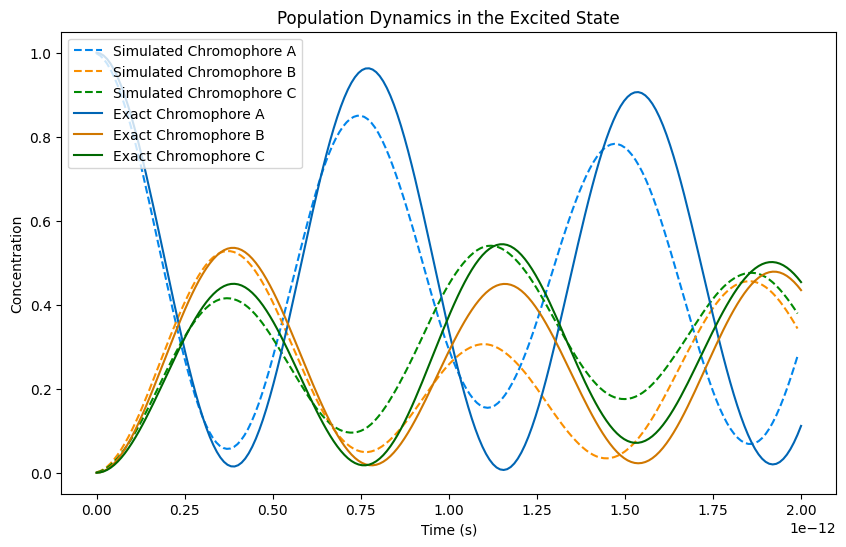

In [36]:
n_a = output.expect[0]
n_b = output.expect[1]
n_c = output.expect[2]
n_l = output.expect[3]
n_A = output.expect[4]
n_B = output.expect[5]
n_C = output.expect[6]

fig, axes = plt.subplots(1, 1, figsize=(10,6))

data_file = 'data/undamped_tests/newvalues.out'
df = pd.read_csv(data_file, delimiter='\s*\(|[\+-]\d\.\d+e[\+-]\d+j\) *\(|[\+-]\d\.\d+e[\+-]\d+j\)', engine = 'python')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.drop(columns=df.columns[len(df.columns)-1], axis=1, inplace=True)
df.columns = df.columns.map(float)
data = df.to_numpy()
columns = df.columns.to_numpy()
columns = columns / 1e12
axes.plot(columns, data[0], '--', label="Simulated Chromophore A", color='#0085ec')
axes.plot(columns, data[1], '--', label="Simulated Chromophore B", color='#fa8f00')
axes.plot(columns, data[2], '--', label="Simulated Chromophore C", color='#008a02')


#axes.plot(tlist, n_a, '--', label="Mode a")
#axes.plot(tlist, n_b, '--', label="Mode b")
#axes.plot(tlist, n_c, '--', label="Mode c")
#axes.plot(tlist, n_l, '--', label="Mode l")

axes.plot(tlist, n_A, label="Exact Chromophore A", color='#0065b4')
axes.plot(tlist, n_B, label="Exact Chromophore B", color='#d07700')
axes.plot(tlist, n_C, label="Exact Chromophore C", color='#006802')
axes.legend(loc=0)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Concentration')
axes.set_title('Population Dynamics in the Excited State')
#plt.grid()
plt.savefig('graph_simulated_vs_exact_nogrid.png', dpi=300)

In [64]:
from qutip.ipynbtools import version_table

version_table()